# Fine-Tuning BERTweet on the Emotin Recognition Dataset

## Loading Libraries and Dataset

Installing and importing the required libraries.

In [1]:
!pip install simpletransformers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm.notebook import tqdm
tqdm.pandas()

import csv
import torch
import logging
import itertools

# Import the ClassificationModel module as we need to do multi-class text classification
from simpletransformers.classification import ClassificationModel

import sklearn
from sklearn.metrics import f1_score, accuracy_score

In [3]:
!pip install emoji
from nltk.tokenize import TweetTokenizer
from emoji import demojize
import re

Loading the dataset

In [4]:
emotion_train_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt", sep="\t", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
emotion_train_df.columns= ["tweet"]
emotion_train_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt", sep="\n", header=None)
emotion_train_labels.columns= ["label"]

emotion_val_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt", sep="\n", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
emotion_val_df.columns= ["tweet"]
emotion_val_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt", sep="\n", header=None)
emotion_val_labels.columns= ["label"]

emotion_test_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt", sep="\n", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
emotion_test_df.columns= ["tweet"]
emotion_test_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt", sep="\n", header=None)
emotion_test_labels.columns= ["label"]

emotion_train_df

,tweet
0,“Worry is a down payment on a problem you may ...
1,My roommate: it's okay that we can't spell bec...
2,No but that's so cute. Atsu was probably shy a...
3,Rooneys fucking untouchable isn't he? Been fuc...
4,it's pretty depressing when u hit pan on ur fa...
...,...
3252,I get discouraged because I try for 5 fucking ...
3253,The @user are in contention and hosting @user ...
3254,@user @user @user @user @user as a fellow UP g...
3255,You have a #problem? Yes! Can you do #somethin...


Making sure that the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets to match the dimensions of their corresponding labels dataframes.

In [5]:
# Checking whether the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets matches the dimensions of their corresponding labels datasets.
print(emotion_train_df.shape, emotion_train_labels.shape)
print(emotion_val_df.shape, emotion_val_labels.shape)
print(emotion_test_df.shape, emotion_test_labels.shape)

(3257, 1) (3257, 1)
(374, 1) (374, 1)
(1421, 1) (1421, 1)


In [6]:
emotion_train = pd.concat([emotion_train_df, emotion_train_labels], axis=1) 
emotion_val = pd.concat([emotion_val_df, emotion_val_labels], axis=1) 
emotion_test = pd.concat([emotion_test_df, emotion_test_labels], axis=1) 

# emotion_train.columns = ["text", "label"]
# emotion_val.columns = ["text", "label"]
# emotion_test.columns = ["text", "label"]

for i in emotion_train["tweet"][:20]:
    print(i)

“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry 
My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs 
No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu 
Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight 
it's pretty depressing when u hit pan on ur favourite highlighter 
@user but your pussy was weak from what I heard so stfu up to me bitch . You got to threaten him that your pregnant . 
Making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist. #college 
Tiller and breezy should do a collab album. Rapping and singing prolly be fire 
@user broadband is shocking regretting signing up now #angry #shouldofgonewithvirgin 
@user Look at those teef! #growl 
@user @user USA was embarrassing to watch. When was the last time you guys won a game..? #hor

## Exploratory Data Analysis

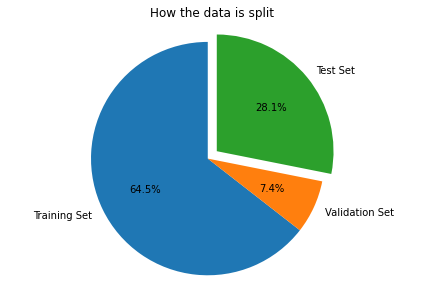

In [7]:
# Pie chart
labels = ['Training Set', 'Validation Set', 'Test Set']
sizes = [len(emotion_train_labels), len(emotion_val_labels), len(emotion_test_labels)]
explode = (0, 0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("How the data is split")
plt.show()

In [8]:
# Checking the labels
emotion_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt", sep="\t", header=None)
emotion_labels

,0,1
0,0,anger
1,1,joy
2,2,optimism
3,3,sadness


Data statitics:

In [9]:
print("Training Data Statistics: ")
print("Total number of tweets:", emotion_train_labels.shape[0])
print("Number of Anger tweets:", int(emotion_train_labels.value_counts()[0]))
print("Number of Joy tweets:", int(emotion_train_labels.value_counts()[1]))
print("Number of Optimism tweets:", int(emotion_train_labels.value_counts()[2]))
print("Number of Sadness tweets:", int(emotion_train_labels.value_counts()[3]), "\n")

print("Validation Data Statistics: ")
print("Total number of tweets:", emotion_val_labels.shape[0])
print("Number of Anger tweets:", int(emotion_val_labels.value_counts()[0]))
print("Number of Joy tweets:", int(emotion_val_labels.value_counts()[1]))
print("Number of Optimism tweets:", int(emotion_val_labels.value_counts()[2]))
print("Number of Sadness tweets:", int(emotion_val_labels.value_counts()[3]), "\n")

print("Testing Data Statistics: ")
print("Total number of tweets:", emotion_test_labels.shape[0])
print("Number of Anger tweets:", int(emotion_test_labels.value_counts()[0]))
print("Number of Joy tweets:", int(emotion_test_labels.value_counts()[1]))
print("Number of Optimism tweets:", int(emotion_test_labels.value_counts()[2]))
print("Number of Sadness tweets:", int(emotion_test_labels.value_counts()[3]))

Training Data Statistics: 
Total number of tweets: 3257
Number of Anger tweets: 1400
Number of Joy tweets: 708
Number of Optimism tweets: 294
Number of Sadness tweets: 855 

Validation Data Statistics: 
Total number of tweets: 374
Number of Anger tweets: 160
Number of Joy tweets: 97
Number of Optimism tweets: 28
Number of Sadness tweets: 89 

Testing Data Statistics: 
Total number of tweets: 1421
Number of Anger tweets: 558
Number of Joy tweets: 358
Number of Optimism tweets: 123
Number of Sadness tweets: 382


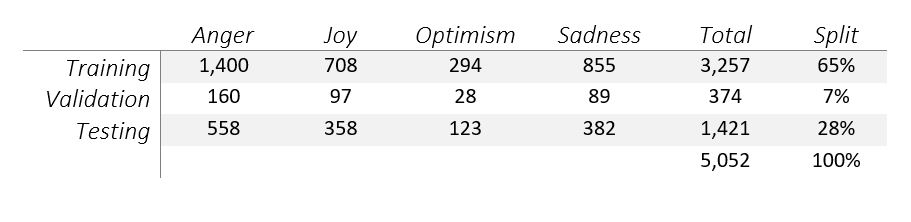

In [10]:
data = emotion_train_labels.groupby("label").sum()
data

""
label
0
1
2
3


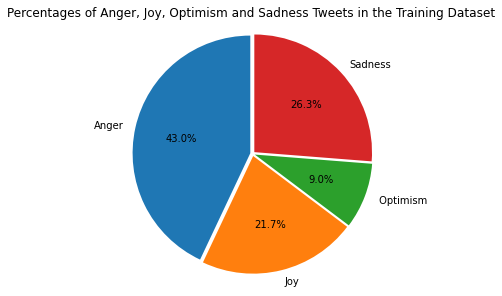

In [11]:
# Pie chart
emo_ang_count = emotion_train_labels[emotion_train_labels.label == 0].shape[0]
emo_joy_count = emotion_train_labels[emotion_train_labels.label == 1].shape[0]
emo_opt_count = emotion_train_labels[emotion_train_labels.label == 2].shape[0]
emo_sad_count = emotion_train_labels[emotion_train_labels.label == 3].shape[0]

labels = ['Anger', 'Joy', ' Optimism', 'Sadness']
sizes = [emo_ang_count, emo_joy_count, emo_opt_count, emo_sad_count]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02, 0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentages of Anger, Joy, Optimism and Sadness Tweets in the Training Dataset")
plt.show()


[Text(0, 0, 'Anger'),
 Text(0, 0, 'Joy'),
 Text(0, 0, ' Optimism'),
 Text(0, 0, 'Sadness')]

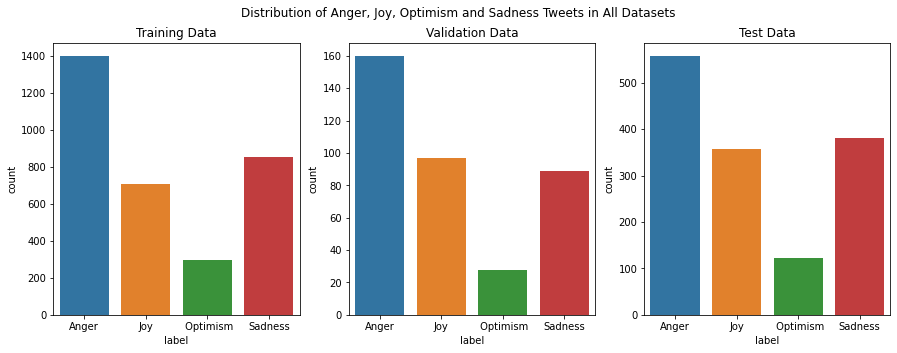

In [12]:
# Count Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of Anger, Joy, Optimism and Sadness Tweets in All Datasets')

sns.countplot(ax=axes[0], x=emotion_train_labels.label)
axes[0].set_title('Training Data')
axes[0].set_xticklabels(labels)

sns.countplot(ax=axes[1], x=emotion_val_labels.label)
axes[1].set_title('Validation Data')
axes[1].set_xticklabels(labels)

sns.countplot(ax=axes[2], x=emotion_test_labels.label)
axes[2].set_title('Test Data')
axes[2].set_xticklabels(labels)

## Exploring the tokenization and attention mask process

In [13]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Emojis are not recognized by the tokenizer so they are tokenized as [UNK].


In [14]:
emotion_train_df.iloc[30,0]

'Why have I only just started watching glee this week I am now addicted 🙄 #glee #GLEEK '

In [15]:
# tokenizing and removing white spaces while keepng punctuation
tweet_sample = emotion_train_df.iloc[30,0]
token_sample = tokenizer.tokenize(tweet_sample)
print(token_sample)

['why', 'have', 'i', 'only', 'just', 'started', 'watching', 'glee', 'this', 'week', 'i', 'am', 'now', 'addicted', '[UNK]', '#', 'glee', '#', 'glee', '##k']


Converting the corpus into tokens and then converting each token to its ID, which is a unique integer representing the index of that token in the vocabulary of the model.


In [16]:
token_id_sample = tokenizer.convert_tokens_to_ids(token_sample)
print(token_id_sample)

[2339, 2031, 1045, 2069, 2074, 2318, 3666, 18874, 2023, 2733, 1045, 2572, 2085, 23042, 100, 1001, 18874, 1001, 18874, 2243]


We have to provide sequences of equal length therefore we'll add some padding, then pass "attention mask" where each term has a value of 1 and each padding token has a value of 0.

Special tokens are needed for separating betwen sentences, that's how BERT initially trained on squence classification.

Exploring types of tokens when encoding them into IDs:


In [17]:
print("Types of tokens and their IDs:", tokenizer.special_tokens_map)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id) # CLS is sequence/text classification task
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.mask_token, tokenizer.mask_token_id)

Types of tokens and their IDs: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
[PAD] 0
[UNK] 100
[CLS] 101
[SEP] 102
[MASK] 103


Exploring the encoding process

In [18]:
encoding = tokenizer.encode_plus( # why plus?
        
    text = tweet_sample,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    # pad_to_max_length=True,
    truncation=True,
    max_length=60, # number of tokens
    padding='max_length',
    return_attention_mask = True,
    return_tensors='pt',  # Return PyTorch tensors, and tf can be used for TensorFlow as well
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The Attention Mask giving the values of 1 to all tokens, except the padding tokens in which it gives them the value of 0.

In [19]:
encoded_seq = encoding['input_ids'][0]
print("Encoded sequence (IDs):\n", encoded_seq)
print("Attention Mask:\n", encoding['attention_mask'])

Encoded sequence (IDs):
 tensor([  101,  2339,  2031,  1045,  2069,  2074,  2318,  3666, 18874,  2023,
         2733,  1045,  2572,  2085, 23042,   100,  1001, 18874,  1001, 18874,
         2243,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Choosing the right size of sequence (or number of tokens) for our dataset is necessary because the larger the sequence length the slower is the process of training the model since there is a corelation between the two.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


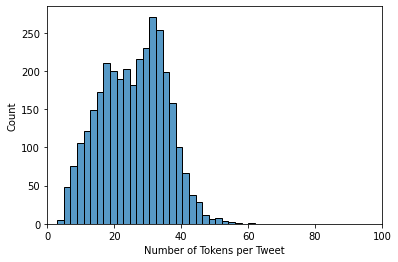

In [20]:
token_lens = []

for each_tweet in emotion_train_df.tweet:
  
  tokens = tokenizer.encode(each_tweet, max_length=512) # max length by the model
  token_lens.append(len(tokens)) 


sns.histplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Number of Tokens per Tweet'); 

## Pre-Processing Steps

In [21]:
# Checking for null values

print("Number of NULL values in the emotion recognition training set: ", emotion_train_df['tweet'].isnull().values.sum())
print("Number of NULL values in the emotion recognition validation set: ", emotion_val_df['tweet'].isnull().values.sum())
print("Number of NULL values in the emotion recognition test set: ", emotion_test_df['tweet'].isnull().values.sum(), '\n')

Number of NULL values in the emotion recognition training set:  0
Number of NULL values in the emotion recognition validation set:  0
Number of NULL values in the emotion recognition test set:  0 



In [22]:
tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll ", " 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.") .replace(" p . m ", " p.m ").replace(" a . m .", " a.m.").replace(" a . m ", " a.m ")

    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    normTweet = normTweet.replace('@USER', '')
    normTweet = normTweet.replace('HTTPURL', '')
    return " ".join(normTweet.split())

# Testing the pre-processing functions
print(normalizeTweet("SC has first two presumptive cases of coronavirus, DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier"))
print(normalizeTweet("So. Many. Plot twists. 😩😭😭😭😭 #Westworld #WestworldFinale "))
print(normalizeTweet("@user @user @user Tamra would F her up if she swung on Tamra\nKelly is a piece of 💩 #needstobeadmitted #bully"))
print(normalizeTweet("in my dream....They were trying to steal my kidney!!!  #blackmarket #whydidiwatchthat "))

SC has first two presumptive cases of coronavirus , DHEC confirms ... via
So . Many . Plot twists . :weary_face: :loudly_crying_face: :loudly_crying_face: :loudly_crying_face: #Westworld #WestworldFinale
Tamra would F her up if she swung on Tamra Kelly is a piece of :pile_of_poo: #needstobeadmitted #bully
in my dream ... They were trying to steal my kidney ! ! ! #blackmarket #whydidiwatchthat


In [23]:
!pip install ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [24]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",
    #    'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

def preprocess_tweets(s):
    s = " ".join(text_processor.pre_process_doc(s))
    s = ' '.join(k for k, _ in itertools.groupby(s.split()))
    s = s.replace("' ", "'").replace(" '", "'")
    s = " ".join(s.split())
    s = s.strip()
    s = s.replace('“', "")
    # s = s.replace("<user>", '')
    # s = demojize(s)
    return s
    
sentences = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
    "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/.",
    "'You have a #problem? Yes! Can you do #something about it? No! Than why  '",
    "on the bright side , my music theory teacher just pocket dabbed and said ,'i know what's hip .'and walked away 😂 😭"
]

for i in sentences:
    print(preprocess_tweets(i))

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
cant wait for the new season of twin peaks ＼(^o^)／ ! david lynch tv series <happy>
i saw the new john doe movie and it suuuuucks ! waisted <money> . bad movies <annoyed>
<user> : can not wait for the <date> sentiment talks ! yaaaaaay ! <laugh> <url>
'you have a problem ? yes ! can you do something about it ? no ! than why'
on the bright side , my music theory teacher just pocket dabbed and said ,'i know what's hip .'and walked away 😂 😭


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [25]:
emotion_train['tweet'] = emotion_train['tweet'].apply(lambda x: preprocess_tweets(x))
emotion_val['tweet'] = emotion_val['tweet'].apply(lambda x: preprocess_tweets(x))
emotion_test['tweet'] = emotion_test['tweet'].apply(lambda x: preprocess_tweets(x))

del emotion_train_df, emotion_train_labels, emotion_val_df, emotion_val_labels, emotion_test_df, emotion_test_labels

In [26]:
emotion_train.head()

,tweet,label
0,worry is a down payment on a problem you may ...,2
1,my roommate : it's okay that we can not spell ...,0
2,no but that's so cute . atsu was probably shy ...,1
3,rooneys fucking untouchable is not he ? been f...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [27]:
emotion_train.label.value_counts()

0    1400
3     855
1     708
2     294
Name: label, dtype: int64

In [28]:
# pre-processed/clean input
for i in emotion_train["tweet"][:20]:
    print(i)

 worry is a down payment on a problem you may never have'. joyce meyer . motivation leadership worry
my roommate : it's okay that we can not spell because we have autocorrect . terrible first world probs
no but that's so cute . atsu was probably shy about photos before but cherry helped her out uwu
rooneys fucking untouchable is not he ? been fucking dreadful again , depay has looked decent ( ish ) tonight
it's pretty depressing when u hit pan on ur favourite highlighter
<user> but your pussy was weak from what i heard so stfu up to me bitch . you got to threaten him that your pregnant .
making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist . college
tiller and breezy should do a collab album . rapping and singing prolly be fire
<user> broadband is shocking regretting signing up now angry should of gone with virgin
<user> look at those teef ! growl
<user> usa was embarrassing to watch . when was the last time you guys won a game . ? hor

In [29]:
# print(stop)

## Fine-Tuning and Evaluating BERTweet Model

In [30]:
import wandb

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print(cuda_available)


train_args = {
              'manual_seed':41,
              'save_steps' : 2000,
              'save_model_every_epoch' : True,
              'save_eval_checkpoints' : True, # s false
              "warmup_steps": 100, # s 100
              'use_early_stopping' : True, # False
              'early_stopping_delta' : 0, # s 0.01
              'early_stopping_metric' : "eval_loss", # s mcc
              'early_stopping_metric_minimize' : False, #True
              'early_stopping_patience' : 3, # s 5
              'evaluate_during_training_steps' : 100, # 2000
              'no_cache' : True, # False
              'num_train_epochs':5, 
              'train_batch_size':32, # 8
              'eval_batch_size': 32,
              'max_seq_length':100, # 128
              'learning_rate':4e-5,
              'optimizer': "AdamW",
              'use_tensorboard': True,
              'evaluate_during_training': True,
              'overwrite_output_dir': True, 
              "use_multiprocessing": False, # False
              "use_multiprocessing_for_evaluation" : False,
              "use_multiprocessed_decoding" : False,
              'wandb_project': "CE888"}

trained_model = ClassificationModel(model_type = 'bertweet',
                                    model_name = 'vinai/bertweet-base',
                                    tokenizer_name = "vinai/bertweet-base",
                                    num_labels=4, 
                                    use_cuda=True, 
                                    #cuda_device=0, 
                                    args=train_args)

True


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classi

In [31]:
trained_model.train_model(emotion_train, eval_df=emotion_val)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.
wandb: Currently logged in as: ihab09 (use `wandb login --relogin` to force relogin)


Running Epoch 0 of 5:   0%|          | 0/102 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Datafr

Running Epoch 1 of 5:   0%|          | 0/102 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 3
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Epoch 2 of 5:   0%|          | 0/102 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 3
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Epoch 3 of 5:   0%|          | 0/102 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 3
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Epoch 4 of 5:   0%|          | 0/102 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Patience of 3 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of bertweet model complete. Saved to outputs/.


(500,
 {'eval_loss': [0.6495605309804281,
   0.662544310092926,
   0.4745056927204132,
   0.47841976583004,
   0.5113696604967117,
   0.4914691125353177,
   0.5809269448121389,
   0.5654677947362264,
   0.6120649402340254],
  'global_step': [100, 102, 200, 204, 300, 306, 400, 408, 500],
  'mcc': [0.7063285073157233,
   0.7368268821905555,
   0.7716533795066624,
   0.7496841411429819,
   0.7438560305122284,
   0.7635935257984705,
   0.7408250401494294,
   0.7624675421013886,
   0.7365831241109168],
  'train_loss': [0.8220083713531494,
   0.7573671936988831,
   0.662325382232666,
   0.22770138084888458,
   0.3339427411556244,
   0.40526649355888367,
   0.4927772879600525,
   0.044121380895376205,
   0.07948604971170425]})

In [32]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

from sklearn.metrics import recall_score

def macro_recall(labels, preds):
    return recall_score(labels, preds, average='macro')

result, model_outputs, wrong_predictions = trained_model.eval_model(emotion_test, mavg_f1=f1_multiclass, acc=accuracy_score, recall = macro_recall)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


Training loss,0.07949
lr,0.0
global_step,500
_runtime,315
_timestamp,1619365783
_step,18
mcc,0.73658
train_loss,0.07949
eval_loss,0.61206


Training loss,█▆▄▅▃▃▁▄▁▁
lr,▄█▇▆▅▅▄▃▂▁
global_step,▁▂▂▂▃▃▃▃▄▅▅▅▆▆▆▇▇██
_runtime,▁▁▂▂▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
mcc,▁▄█▆▅▇▅▇▄
train_loss,█▇▇▃▄▄▅▁▁
eval_loss,██▁▁▂▂▅▄▆


INFO:simpletransformers.classification.classification_model:{'mcc': 0.7977407441648939, 'eval_loss': 0.4961513540811009, 'mavg_f1': 0.8327445875722336, 'acc': 0.8578465869106263, 'recall': 0.8281677912435716}


In [33]:
result

{'acc': 0.8578465869106263,
 'eval_loss': 0.4961513540811009,
 'mavg_f1': 0.8327445875722336,
 'mcc': 0.7977407441648939,
 'recall': 0.8281677912435716}

Graphs showing the training process as imported from the Weights and Biases platform (wandb.ai).

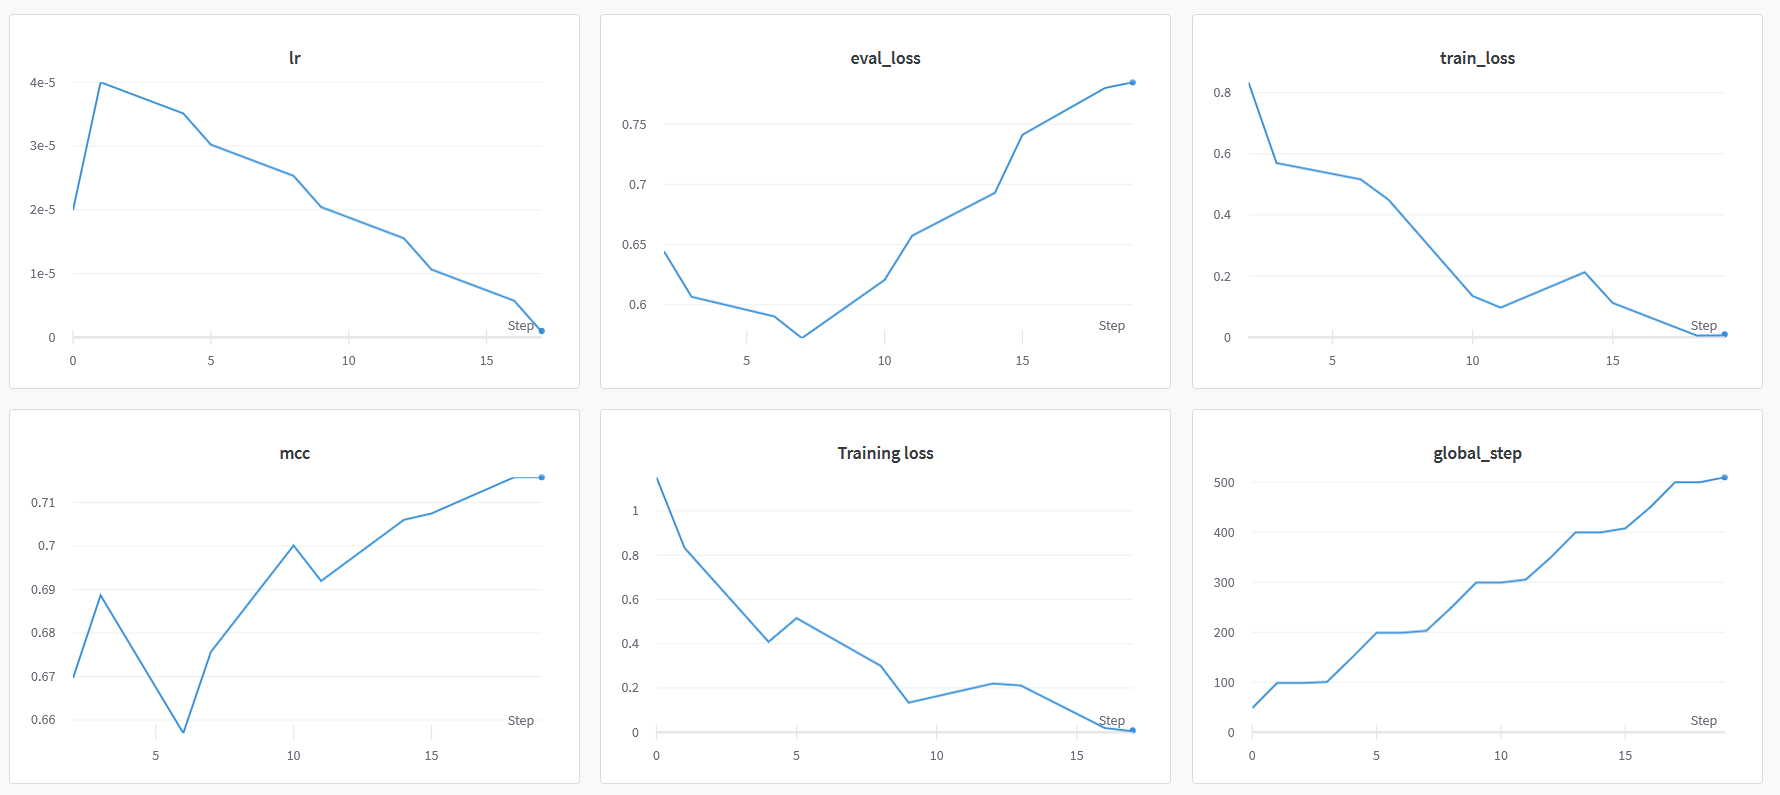

The confustion matrix showing that the first class "Anger" is correctly classified most of the time, while the third class "Joy" is widely missclassified. 

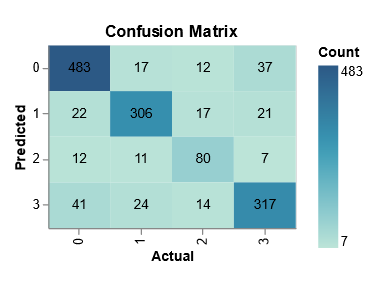

### Macro-Average F1 Score

In [34]:
print("Macro-Average F1 Score: ", result['mavg_f1']*100)

Macro-Average F1 Score:  83.27445875722336


In [35]:
# Plays an audio message as a notification when the training process is done.
import IPython.display as display
display.Audio(url="https://static.sfdict.com/audio/C07/C0702600.mp3", autoplay=True)

## Saving the best model

In [ ]:
# Transforming the model folder into a single compressed file.
!zip -r /content/outputs/best_model_file.zip /content/outputs/best_model

In [ ]:
# Downloading the model locally.
from google.colab import files
files.download("/content/outputs/best_model_file.zip")

## Loading the saved model

In [ ]:
# If you don't want to retrain the model, you can load the best saved model directly by running the code below.
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print(cuda_available)

import wandb

trained_model = ClassificationModel(
    "bertweet", "outputs/best_model"
    # "bertweet", "outputs/checkpoint-612-epoch-6"
)